**Import Libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
import joblib
import os

**Load Dataset**

In [8]:
filename = "/content/credit_scoring_sample.csv"

**Checking EDA**

In [10]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (45063, 8)
Columns: ['SeriousDlqin2yrs', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'MonthlyIncome', 'NumberOfDependents']


In [11]:
print(df.head())

   SeriousDlqin2yrs  age  NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  \
0                 0   64                                     0     0.249908   
1                 0   58                                     0  3870.000000   
2                 0   41                                     0     0.456127   
3                 0   43                                     0     0.000190   
4                 1   49                                     0     0.271820   

   NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  \
0                        0                                     0   
1                        0                                     0   
2                        0                                     0   
3                        0                                     0   
4                        0                                     0   

   MonthlyIncome  NumberOfDependents  
0         8158.0                 0.0  
1            NaN                 0.0  

In [12]:
print(df.dtypes)

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object


In [13]:
print(df.isnull().sum())

SeriousDlqin2yrs                           0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
NumberOfTimes90DaysLate                    0
NumberOfTime60-89DaysPastDueNotWorse       0
MonthlyIncome                           8643
NumberOfDependents                      1117
dtype: int64


In [14]:
cols = [
    "age",
    "DebtRatio",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents",
    "SeriousDlqin2yrs"   # target
]

In [15]:
missing_cols = [c for c in cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"The following required columns are missing from the CSV: {missing_cols}")

In [16]:
df = df[cols].copy()
print("\nUsing columns:", df.columns.tolist())


Using columns: ['age', 'DebtRatio', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents', 'SeriousDlqin2yrs']


**Target distribution**


Target distribution:
SeriousDlqin2yrs
0    35037
1    10026
Name: count, dtype: int64


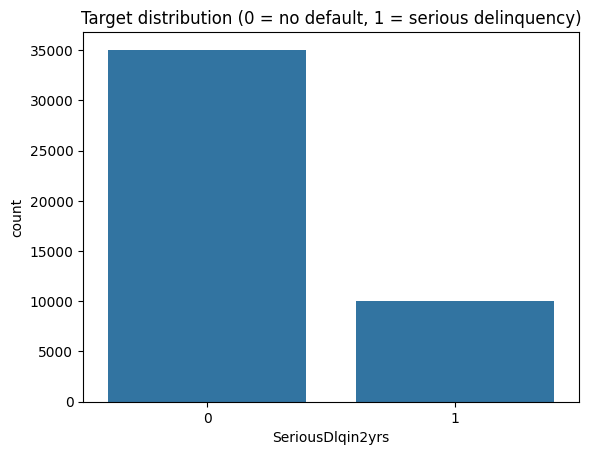

In [17]:
target_col = "SeriousDlqin2yrs"
print("\nTarget distribution:")
print(df[target_col].value_counts())
sns.countplot(x=target_col, data=df)
plt.title("Target distribution (0 = no default, 1 = serious delinquency)")
plt.show()

In [19]:
num_cols = [c for c in cols if c != target_col]
for c in num_cols:
    if df[c].isnull().any():
        med = df[c].median()
        df[c].fillna(med, inplace=True)
        print(f"Filled missing in {c} with median = {med}")

Filled missing in NumberOfDependents with median = 0.0


/tmp/ipython-input-281709697.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(med, inplace=True)


**Feature correlation**

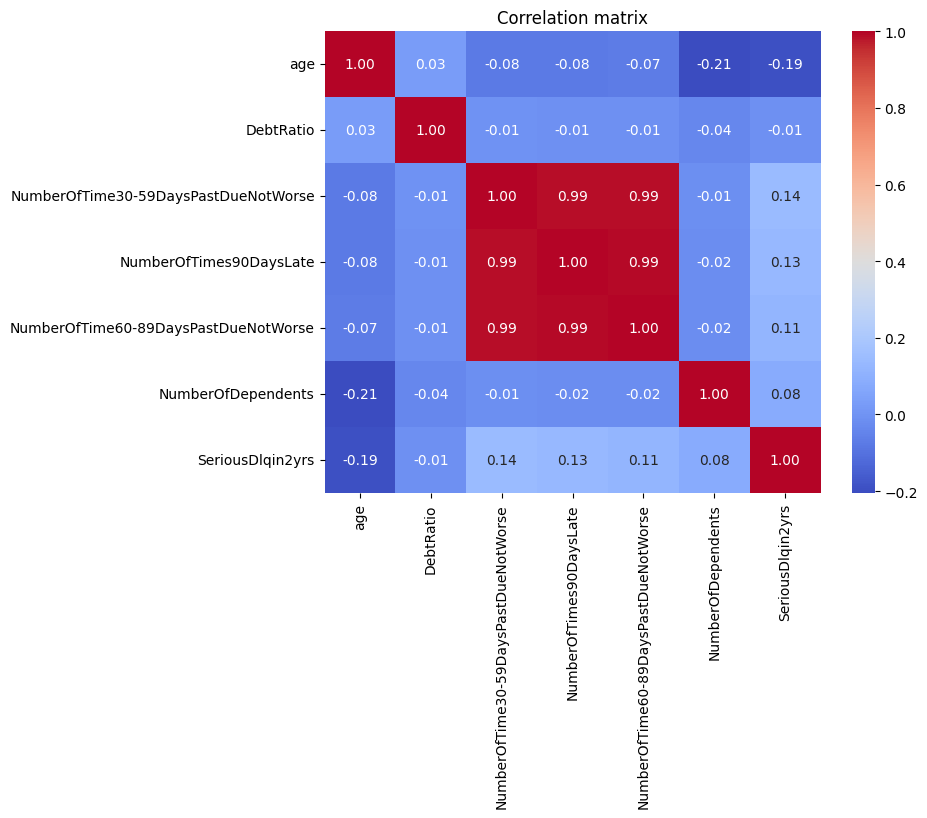

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

**Define X and y  split**

In [21]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTrain/test sizes:", X_train.shape, X_test.shape)


Train/test sizes: (36050, 6) (9013, 6)


** scale numeric features**

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Baseline models**

In [23]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    try:
        y_proba = model.predict_proba(X_test_scaled)[:,1]
    except:
        y_proba = None

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC: {auc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)
    results[name] = {"model": model, "y_pred": y_pred, "y_proba": y_proba}



=== LogisticRegression ===
              precision    recall  f1-score   support

           0     0.8830    0.7988    0.8388      7008
           1     0.4725    0.6299    0.5400      2005

    accuracy                         0.7612      9013
   macro avg     0.6777    0.7144    0.6894      9013
weighted avg     0.7917    0.7612    0.7723      9013

ROC-AUC: 0.7919
Confusion matrix:
 [[5598 1410]
 [ 742 1263]]

=== DecisionTree ===
              precision    recall  f1-score   support

           0     0.8412    0.8456    0.8434      7008
           1     0.4502    0.4419    0.4460      2005

    accuracy                         0.7558      9013
   macro avg     0.6457    0.6438    0.6447      9013
weighted avg     0.7542    0.7558    0.7550      9013

ROC-AUC: 0.6435
Confusion matrix:
 [[5926 1082]
 [1119  886]]

=== RandomForest ===
              precision    recall  f1-score   support

           0     0.8566    0.8828    0.8695      7008
           1     0.5413    0.4833    0.51

**Choose best by ROC-AUC **

In [24]:
best_name = None
best_auc = -1
for name, res in results.items():
    if res["y_proba"] is not None:
        auc = roc_auc_score(y_test, res["y_proba"])
        if auc > best_auc:
            best_auc = auc
            best_name = name
if best_name:
    print(f"\nBest model by ROC-AUC: {best_name} (AUC = {best_auc:.4f})")
    best_model = results[best_name]["model"]
else:
    best_name = "RandomForest"
    best_model = models["RandomForest"]
    print("\nNo probability outputs found; defaulting best model to RandomForest.")


Best model by ROC-AUC: LogisticRegression (AUC = 0.7919)


**ROC curve for best model**

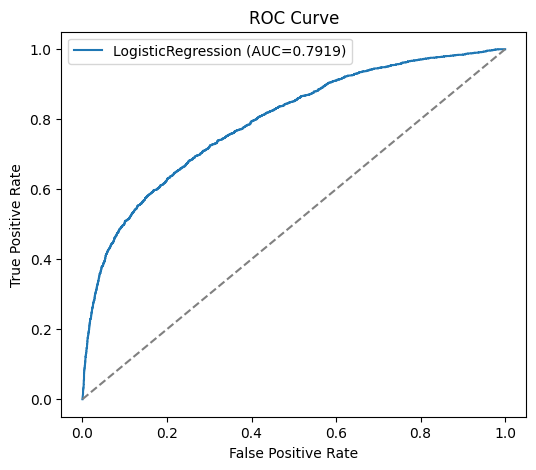

In [25]:
y_proba_best = None
try:
    y_proba_best = best_model.predict_proba(X_test_scaled)[:,1]
except:
    pass

if y_proba_best is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_best)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{best_name} (AUC={roc_auc_score(y_test, y_proba_best):.4f})")
    plt.plot([0,1],[0,1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [27]:
# Save the best model and scaler
joblib.dump(best_model, "best_credit_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully!")


Model and scaler saved successfully!


In [29]:
import joblib

# Load saved model and scaler
best_model = joblib.load("best_credit_model.pkl")
scaler = joblib.load("scaler.pkl")

print(" Model and scaler loaded successfully!")


 Model and scaler loaded successfully!


In [30]:

import gradio as gr
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# === Load or use trained model ===
best_model = results[best_name]["model"]
scaler = StandardScaler().fit(X_train)  # reuse same scaling

# === Define prediction function ===
def predict_default(age, DebtRatio, NumberOfTime30_59DaysPastDueNotWorse,
                    NumberOfTimes90DaysLate, NumberOfTime60_89DaysPastDueNotWorse,
                    NumberOfDependents):
    # Create DataFrame
    data = pd.DataFrame([[
        age,
        DebtRatio,
        NumberOfTime30_59DaysPastDueNotWorse,
        NumberOfTimes90DaysLate,
        NumberOfTime60_89DaysPastDueNotWorse,
        NumberOfDependents
    ]], columns=[
        "age",
        "DebtRatio",
        "NumberOfTime30-59DaysPastDueNotWorse",
        "NumberOfTimes90DaysLate",
        "NumberOfTime60-89DaysPastDueNotWorse",
        "NumberOfDependents"
    ])

    # Scale features
    data_scaled = scaler.transform(data)

    # Predict
    pred = best_model.predict(data_scaled)[0]
    proba = best_model.predict_proba(data_scaled)[0][1]

    result = "⚠️ High Risk of Default" if pred == 1 else "✅ Low Risk of Default"
    return f"{result}\nProbability of default: {proba:.2f}"

# === Gradio Interface ===
interface = gr.Interface(
    fn=predict_default,
    inputs=[
        gr.Number(label="Age", value=40),
        gr.Number(label="Debt Ratio", value=0.5),
        gr.Number(label="Number of Times 30-59 Days Past Due (Not Worse)", value=0),
        gr.Number(label="Number of Times 90 Days Late", value=0),
        gr.Number(label="Number of Times 60-89 Days Past Due (Not Worse)", value=0),
        gr.Number(label="Number of Dependents", value=1)
    ],
    outputs=gr.Textbox(label="Prediction Result"),
    title="💳 Credit Scoring Prediction App",
    description=(
        "Enter customer financial and behavioral data to predict the likelihood "
        "of serious delinquency (default) within 2 years using the trained model."
    ),
    theme="default"
)

# === Launch app ===
interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1aef7a5e6434389c53.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
